In [1]:
import os, sys, subprocess, glob, numpy as np, pickle as pkl
import matplotlib.pyplot as plt, itertools
from scipy.optimize import curve_fit

%matplotlib inline

In [14]:
npy_dir = './Tjump_dists/'
Tm_dict = {'GC-core':(324, 57), 'GC-mix':(324, 56), 
           'GC-end':(318, 47), 'AT-all':(309, 40)}

temp_list = []
dist_list = []

seq = 'AT-all'
n_frames = 50000

for npy in sorted(os.listdir(npy_dir)):

    # load coords for each seq
    if seq in npy and '299' not in npy: #'308' not in npy and '314' not in npy:
        
        temp = int(npy.split('_')[1].replace('T-',''))
        temp_list.append(temp)
        dist = np.load(npy_dir + npy)[:, :n_frames]
        dist_list.append(dist)
        print(temp, dist.shape)
        
        dim = dist.shape

304 (120, 50000, 10)
309 (120, 50000, 10)
314 (120, 50000, 10)
319 (120, 50000, 10)
324 (120, 50000, 10)


### Look for slow relaxation time by monitoring the distribution of dissociation times. Use intermolecular core distances as metric for dissociation.

In [15]:
def get_diss_list(temp_list, dist_list, slow_cut=2, window=10):
    '''returns list of all dissociation times for each temperature of a given seq'''

    slow_bp = 4
    diss_list = []

    for temp, dist in zip(temp_list, dist_list):

        diss_times = []
        dim = dist.shape
        for i in range(dim[0]):
            for j in range(dim[1] - window):

                # find average over given window
                w_avg = np.mean(dist[i, j:j+window, slow_bp])
                if w_avg > slow_cut:

                    # append all dissociation times
                    diss_times.append(j)
                    break

        print(temp, len(diss_times))
        diss_list.append(np.array(diss_times))
        
    return diss_list

diss_list = get_diss_list(temp_list, dist_list)

304 3
309 16
314 43
319 95
324 119


### Find cumulative sum distribution with exponentials for each temperature

T = 304   r2 = 0.67
29583.9 100 100
T = 309   r2 = 0.88
144367.3 100 100
T = 314   r2 = 0.89
444802.5 100 100
T = 319   r2 = 0.99
1558547.8 100 100
T = 324   r2 = 0.98
4027546.1 100 100
[5.79967660e+01 4.93148866e+00 1.00000000e+04] 19332.255330546835
total r2 = 0.9423662572056231


/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


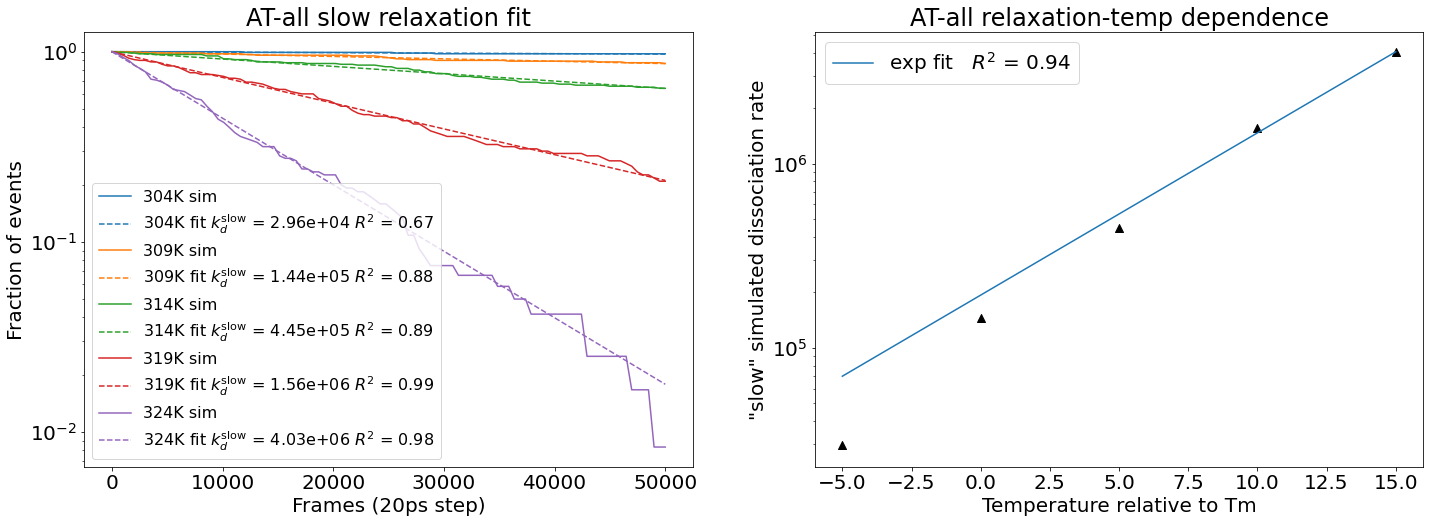

In [16]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

ts = 20*10**-12
R = 8.314
n_bins = 100

fluct_correction = False

# sim and experimental temps for each seq
(Tsim, Tm) = Tm_dict[seq]

# starting point for fitting
a_lin, b_lin = 2.9*10**5, -6.1*10**6
a_exp, b_exp, c_exp = 0.003, 4, 10000

def exponenial_func(x, a, b, c):
    return a*np.exp(x/b)  #+c

# fix intercept at zero and asymptote to 1
def exponenial_func_asym(x, b):
    return 1 - np.exp(x/b)

# keep values the same as experiment except for CG speed up factor
def exponenial_accleration(x, acc):
    return acc*( a_exp*np.exp(x/b_exp) + c_exp) #acc*( a_exp*np.exp(x/b_exp)+ c_exp ) 

def plot_diss(temp_list, diss_list, seq, axes):
    
    
    # effective temp relative to experiment
    temp_eff = np.array(temp_list) - Tsim + Tm
    tm_rel = np.array(temp_list) - Tsim #- Tm_dict[seq] #np.array([3, 8, 13, 18])
    p0 = (a_exp, b_exp, c_exp)
    
    exp_list = []
    sig_list = []

    ax = axes[0]
    if fluct_correction: ax.set_title(f'{seq} slow relaxation fit with corr')
    else: ax.set_title(f'{seq} slow relaxation fit')

    for temp, diss_times in zip(temp_eff, diss_list):

        cumsum = []
        bin_axis = np.linspace(0, dim[1], n_bins)

        # apply fluctation correction on fraction of dissociated pairs
        for j in bin_axis:
            f = np.sum(diss_times < j)/dim[0] # finite fraction
            if not fluct_correction:
                cumsum.append(f)
                
            else:
                phi = f/(1 - f)
                if phi == 0: thermo_fract = 0
                else: thermo_fract = 1 + 1/(4*phi) - ((1+1/(4*phi))**2 - 1)**0.5
                cumsum.append(thermo_fract)

        # fit exponential:
        popt, pcov = curve_fit(exponenial_func_asym, bin_axis, cumsum, p0=(-200))
        sig_rel = np.sqrt(pcov[0, 0])/popt[0]
        #sig_rel = np.sqrt(-pcov[0, 0]/popt[0])

        fit = exponenial_func_asym(bin_axis, *popt)
        rate = 1/-(ts*popt[0])
        exp_list.append(rate)

        # compute one standard deviation relative to rate
        sig_list.append(rate*sig_rel)
        
        # convert for log plot
        cumsum = (1-np.array(cumsum))

        # calculate R^2 log for goodness of fit for each temp
        ss_res = np.sum((np.log(cumsum[:60]) - np.log(1-fit[:60])) ** 2)
        ss_tot = np.sum((np.log(cumsum[:60]) - np.mean(np.log(cumsum[:60]))) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        print(f'T = {temp-Tm+Tsim}   r2 = {np.round(r2, 2)}')
        print(np.round(rate, 1), len(cumsum), len(fit))

        color = next(ax._get_lines.prop_cycler)['color']
        ax.plot(bin_axis, cumsum, label=f'{temp-Tm+Tsim}K sim', color=color)
        kd_text = '$k_d^\mathrm{slow}$'
        ax.plot(bin_axis, 1-fit, label=f'{temp-Tm+Tsim}K fit {kd_text} = {rate:.2e} $R^2$ = {np.round(r2, 2)}', 
                    linestyle='dashed', color=color)

        ax.set_xlabel('Frames (20ps step)')
        ax.set_ylabel('Fraction of events')
        ax.legend(fontsize=16)
        
    ax = axes[1]
    ax.set_title(f'{seq} relaxation-temp dependence')

    #print(temp_list, exp_list)

    # Fit a new exponetial curve to the coefficient at each temp 
    x_fit = np.linspace(temp_eff[0], temp_eff[-1], 101)
    popt, pcov = curve_fit(exponenial_func, temp_eff, exp_list, p0=p0)
    temp_fit = exponenial_func(x_fit, *popt) #*popt)
    print(popt, popt[0]/a_exp)

    # Fit based using experimental data, using only acceleratoin coefficient
    acc, pcov = curve_fit(exponenial_accleration, temp_eff, exp_list, p0=(10))
    acc_fit = exponenial_accleration(x_fit, acc[0])
    #print(acc)

    ax.scatter(tm_rel, exp_list, color='black', s=64, marker='^') #,label='coefficients')
    ax.errorbar(tm_rel, exp_list, yerr=sig_list, color='black', fmt='none')
    
    # calculate R^2 log for goodness of fit for all plots
    ss_res = np.sum((np.log(exp_list) - np.log(temp_fit[np.arange(0, 101, 25)])) ** 2)
    ss_tot = np.sum((np.log(exp_list) - np.mean(np.log(exp_list))) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    print(f'total r2 = {r2}')

    ax.plot(x_fit-x_fit[0]+tm_rel[0], temp_fit, label=f'exp fit   $R^2$ = {np.round(r2, 2)}')
    #ax.plot(x_fit-Tm, acc_fit, label='accelerated fit')

    ax.set_xlabel('Temperature relative to Tm')
    ax.set_ylabel('"slow" simulated dissociation rate')
    ax.legend()
    
    return exp_list, sig_list
    
# plot dissocation fits on specified axis
plot_diss(temp_list, diss_list, seq, axes)
plt.subplots_adjust(wspace=0.2)
axes[0].set_yscale('log')
axes[1].set_yscale('log')


In [17]:
## try changing salt concentration to 100 and see if this leads to more events?
## generate the same exponentials as above

# get rmsd to look for other intact duplexes during the run
def rmsd_comparison(frame_diff):
    return np.sqrt(np.sum((frame_diff)**2, axis=1))

#def find_reference_struct():

def get_fray_list(window, fast_cut, fast_bps, dist_list, temp_list):

    fray_list = []
    for temp, dist in zip(temp_list, dist_list):

        fray_times = []
        dim = dist.shape
        diff_arr = np.subtract(dist[0, :, :], dist[0, 0, :])
        rmsd = rmsd_comparison(diff_arr)
        #print(dist[0, :, :].shape, dist[0, 0, :].reshape(1, 10).shape, diff_arr.shape, rmsd.shape)
        #plt.plot(rmsd)

        for i in range(dim[0]):
            
            #keep track of top and bottom fraying indepdendently
            top_frayed, bot_frayed = False, False
            
            for j in range(dim[1] - window):
                
                w_top = np.mean(dist[i, j:j+window, fast_bps[0]])
                w_bot = np.mean(dist[i, j:j+window, fast_bps[1]]) 
                
                if w_top > fast_cut and not top_frayed:
                    fray_times.append(j)
                    top_frayed = True
                if w_bot > fast_cut and not bot_frayed:
                    fray_times.append(j)
                    bot_frayed = True
                if top_frayed and bot_frayed:
                    break
                    
        #print(temp, len(fray_times), 1/(ts*np.mean(fray_times)), '\n')
        fray_list.append(np.array(fray_times))
    
    return(fray_list)
        
window = 1
fast_cut = 1.2
fast_bps = (0, 9) #(1, 8)

fray_list = get_fray_list(window, fast_cut, fast_bps, dist_list, temp_list)

### For fast signal, look for some fast (fraying) dynamic that correlates most closely to experiment

T = 264   r2 = 0.99
624216225.7
T = 269   r2 = 0.99
830183698.1
T = 274   r2 = 0.99
928803775.0
T = 279   r2 = 0.98
1331979860.0
T = 284   r2 = 0.99
1630141218.8
[-164.2510758]


/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


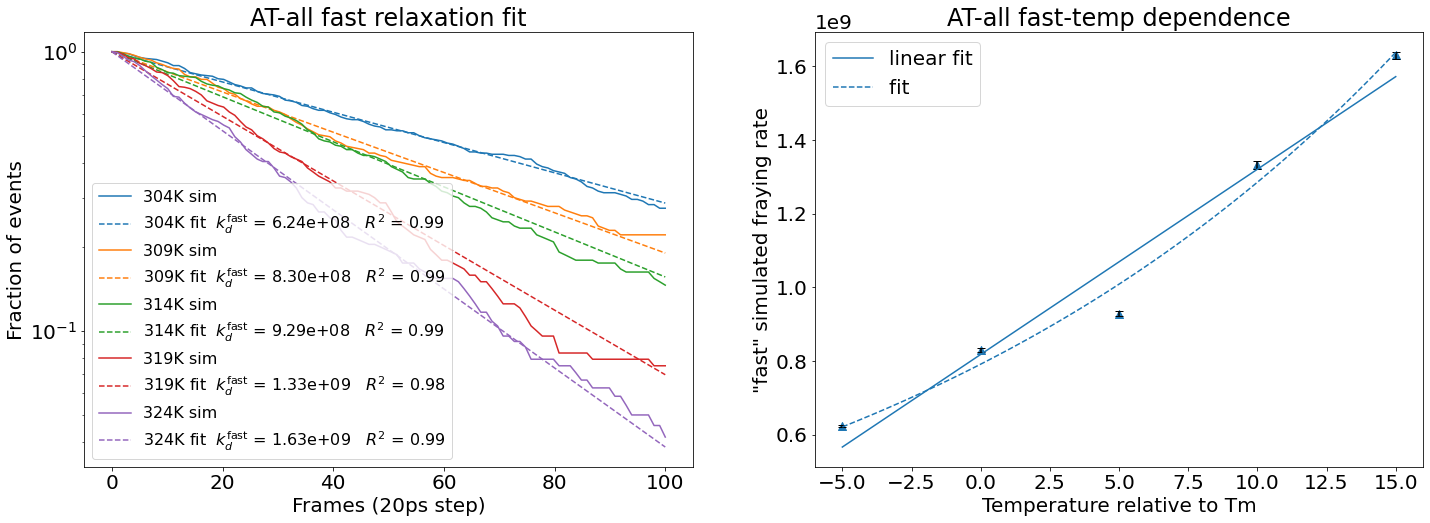

In [18]:

def linear_func(x, a, b):
    return a*x+b

def linear_acceleration(x, acc):
    return acc*(a_lin*x + b_lin) #acc*(a_lin*x+b_lin)

def exponenial_fast(x, b):
    return 2*(1 - np.exp(x/b))

def plot_exp_fits(ax, temp_eff, fray_list, frame_range):

    exp_list = []
    sig_list = []
    
    for temp, fray_times in zip(temp_eff, fray_list):

        cumsum = []
        bin_axis = np.linspace(frame_range[0], frame_range[1], n_bins)

        for j in bin_axis:
            cumsum.append(np.sum(fray_times < j)/dim[0])

        # fit exponential:
        popt, pcov = curve_fit(exponenial_fast, bin_axis, cumsum, p0=(-20000))
        
        # compute one standard deviation from popt
        # p_sigma = np.sqrt(np.diag(pcov))[0]
        # sig_list.append(1/(ts*p_sigma))
        sig_rel = np.sqrt(pcov[0, 0])/popt[0]
        
        fit = exponenial_fast(bin_axis, *popt)
        rate = 1/-(ts*popt[0])
        exp_list.append(rate)

        # compute one standard deviation relative to rate
        sig_list.append(rate*sig_rel)
        
        # convert for log plot
        cumsum = (1-np.array(cumsum)/2)
        
        # calculate R^2 log for goodness of fit for each temp
        ss_res = np.sum((np.log(cumsum[:80]) - np.log(1-fit[:80]/2)) ** 2)
        ss_tot = np.sum((np.log(cumsum[:80]) - np.mean(np.log(cumsum[:80]))) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        print(f'T = {temp-Tm+Tsim}   r2 = {np.round(r2, 2)}')
        print(np.round(rate, 1))

        if ax is not None:
            color = next(ax._get_lines.prop_cycler)['color']
            ax.plot(bin_axis, cumsum, label=f'{temp+Tsim}K sim', color=color)
            kd_text = '$k_d^\mathrm{fast}$'
            ax.plot(bin_axis, 1-np.array(fit)/2, label=f'{temp+Tsim}K fit  {kd_text} = {rate:.2e}   $R^2$ = {np.round(r2, 2)}', 
                    linestyle='dashed', color=color)

            ax.set_title(f'{seq} fast relaxation fit')
            ax.set_xlabel('Frames (20ps step)')
            ax.set_ylabel('Fraction of events')
            ax.legend(fontsize=16) #title='Temp relative to Tm', fontsize=16)
        
    return exp_list, sig_list
        
def plot_fast_fits(ax, linear_func, temp_eff, exp_list, sig_list=None, plot_acc=True, plot_full=1):

    color = next(ax._get_lines.prop_cycler)['color']

    # Fit a new exponetial curve to the coefficient at each temp 
    popt, pcov = curve_fit(linear_func, temp_eff, exp_list, p0=p0_lin)
    temp_fit = linear_func(temp_eff, *popt) #*popt)
    #print(popt[0]/a_lin)

    # Fit based using experimental data, using only acceleratoin coefficient
    acc, pcov = curve_fit(linear_acceleration, temp_eff, exp_list, p0=[10])
    acc_fit = linear_acceleration(temp_eff, acc[0])
    print(acc)

    ax.scatter(temp_eff, exp_list, color=color, s=64, marker='^')  #, label='coefficients')
    #ax.scatter(temp_eff, exp_list, color='black', s=64, marker='^', label='coefficients')
    
    if sig_list is not None:
        ax.errorbar(temp_eff, exp_list, yerr=sig_list, color='black', fmt='none', capsize=4)
    
    x_fit = np.linspace(temp_eff[0], temp_eff[-1], 100)
    exp_c, _ = curve_fit(exponenial_func, temp_eff, exp_list, p0=[6e+07, 10, 2e+08])
    
    if plot_full==1:
        ax.plot(temp_eff, temp_fit, label='linear fit', color=color) #label='full fit')
        ax.plot(x_fit, exponenial_func(x_fit, *exp_c), label='fit ', linestyle='dashed', color=color)
        
    elif plot_full==2:
        ax.plot(temp_eff, temp_fit, label=seq, color=color, ) #label='full fit')
        ax.plot(x_fit, exponenial_func(x_fit, *exp_c), label='exponential fit', linestyle='dashed', color=color)
    
    if plot_acc:
        ax.plot(temp_eff, acc_fit, label='accelerated fit', color=color)
        
    ax.set_title(f'{seq} fast-temp dependence')
    ax.set_xlabel('Temperature relative to Tm')
    ax.set_ylabel('"fast" simulated fraying rate')
    ax.legend()

    plt.subplots_adjust(wspace=0.2)
    return popt
    
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
n_bins = 100
frame_range = (0, 100)

# effective temp relative to experiment
temp_eff = np.array(temp_list) - Tsim #+ Tm
p0_lin = (a_lin, b_lin)
    
exp_list, sig_list = plot_exp_fits(axes[0], temp_eff, fray_list, frame_range)
popt = plot_fast_fits(axes[1], linear_func, temp_eff, exp_list, 
                      sig_list=sig_list, plot_acc=False, plot_full=1)

axes[0].set_yscale('log')


In [ ]:
## aggregate slow responses for all sequences 
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# redefine temp dict, check relative to Tm
seq_list = ['GC-core', 'AT-all', 'GC-mix', 'GC-end']
save_dict = {}
n_frames = 30000

# some hyperparams for slow response, these should not affect things too much
slow_cut, window= 1.3, 100

for i, seq in enumerate(seq_list):
    
    temp_list = []
    dist_list = []
    
    for npy in sorted(os.listdir(npy_dir)):

        # load coords for each seq
        if seq in npy:

            temp = int(npy.split('_')[1].replace('T-',''))
            temp_list.append(temp)
            dist = np.load(npy_dir + npy)[:, :n_frames]
            dist_list.append(dist)
            print(temp, dist.shape)
            
    dist_list, temp_list = dist_list[-5:], temp_list[-5:]
    diss_list = get_diss_list(temp_list, dist_list, slow_cut=slow_cut, window=window)
    exp_list, sig_list = plot_diss(temp_list, diss_list, seq, axes)
    save_dict[seq] = (temp_list, exp_list, sig_list)

axes[0].set_title('All slow relaxations')
axes[1].set_title('Slow response fits')
